# Description
Uses Approximative Baysian Computation to fit $b1$ and $\beta$ to model. Reduced $\chi^2$ was chosen as a distance function. See `Fit_b1_beta_minchi2.ipynb` for more elementary approach to same fitting task as well as some background discussion. Since I consider different fitting methods in different notebooks, I moved common functions into `inv_cov_funcs.py`.

In ABC we need to compute inverse covariance matrix many times. Following https://arxiv.org/pdf/1509.04293.pdf eq 15, 16 we need $P(k,\mu)$ for the computations. This power spectrum can either be based derived from a model or the data. In the former case, the covariance matrix depends on the candidate value of the model parameters such that for every candidate $b1$ and $\beta$ we would have to compute the covariance matrix from scratch. As ABC considers a large number of candidates, this becomes very inefficient. Instead, we use $P(k,\mu)$ as inferred from the data following eq 24 of the above paper. This removes the $b1$, $\beta$ dependence and only introduces an error of an error which can be ignored in light of the desired accuracy of this analysis. This power spectrum is stored in `Pkmus`.

When trying to use `Pkmus[i] = r.power['mu']` as the i-th percentile data $P(k,\mu)$ to estimate the covariance matrix, issues occur as a lot of elements are NaN (when no Fourier modes can contained in a k,mu bin to average the power over). Above alternative of using combination of multipoles weighted by Legendre polynomials works fine.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import bayes_mvs

import inv_cov_funcs as icf
import classylss
import fitsio
from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu') 
sigma8_lin = Plin.sigma8
sigma8_true = 0.8111 
f0_true = cosmo.scale_independent_growth_rate(redshift)

dk = 0.01
ells = [0,2]

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8, w0_fld, wa_fld
  self.engine = ClassEngine(pars)
/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [5]:
# load computed power spectra to deduce multipoles in each bin and P(k,mu) from data
k, shotnoise, n_ptile, Pk_ells, mus, Pkmus = icf.load_power_data('/home/jwack/main/fit_linear_model_in_density_bins/', ells, get_Pkmus=True)

This implementation of chi2, only works for the purely linear Kaiser law for mono and quadrupole due to hard coding the multipoles. Using one of the helper functions of `in_cov_funcs.py`. A more general alternative (works for any ells and modified Kaiser law when call in `in_cov_funcs.make_Pkmu` is changed) is:

```
model_multipoles = np.empty((len(ells), len(k)))
for i,ell in enumerate(ells):
    model_multipoles[i] = in_cov_funcs.model_multipole(k, ell, b1, beta, Plin)
```

In [6]:
def chi2(theta, k, data_multipoles, C_inv):
    '''Find chi^2 as explained in Fitting_b1_different_kmax.ipynb. 
    data_multipoles must be an array of shape (len(ells), len(k)).
    theta is the model parameter array: theta = [b1, beta]. See above markdown for more general alternative.'''
    b1, beta = theta
    ells = [0,2]
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    
    return D_M@(C_inv @ D_M)


def ABC(k, data_multipoles, nreps, ranges, epsilon, C_inv):
    """Perfrom Approximate Bayesian computation with uniform priors.
    
    Parameters
    ----------
    k : array
        Mid point of k bins upto which we seek to fit the model to the data.
    data_multipoles: 
        2D array of shape (number multipoles, length k) containing multipole data for all k.
    nreps : int
        The number of trials.
    ranges : list of tupels of floats
        Each tuple defines the bounds of the model parameter range.
    epsilon : float
        The maximum distance for a model to be accepted.

    Returns
    -------
    selected : array
        Parameters of the accepted models.
    acc_rate : float
        acceptance rate in percent
    """
    selected = []

    t1 = time.time()
    for i in range(nreps):
        # create trial parameters from uniform prior.
        pars = [np.random.uniform(*r) for r in ranges]
        # Take reduced chi2 as distance meassure
        dist = chi2(pars, k, data_multipoles, C_inv) / (2*len(k)-2)
        
        if dist < epsilon:
            selected.append(pars)
            
    t2 = time.time()
    #print("Epsilon=%.2f, time:%.2f sec"%(epsilon,t2-t1))
    
    return np.array(selected)

In [7]:
# arrays full of NaN. When not enough candidates accepted, NaN remains and percentile will not be plotted
b1_fits, beta_fits = np.full(n_ptile, np.nan), np.full(n_ptile, np.nan) # mean of accepted parameters
b1_cred, beta_cred = np.full((n_ptile,2), np.nan), np.full((n_ptile,2), np.nan) # 3 sigma credibility interval
reduced_chi2 = np.full(n_ptile, np.nan) # reduced chi at mean of accepted parameters 

ranges = [(0,3), (-1,2)]
reps = int(5e4)

for i in range(n_ptile):
    t1 = time.time()
    # change data format of Pk_ells to be compatible with chi2 minimization code 
    data_multipoles = np.zeros((len(ells), len(k)))
    data_multipoles[0] = Pk_ells[i][0]
    data_multipoles[1] = Pk_ells[i][1]
    
    C_inv = icf.gaussian_cov_mat_inv(k, ells, BoxSize, shotnoise, dk, Pkmus[i], mus)
    
    sel = np.zeros((0,2))
    count = 0
    # repeat sampling until enough parameter have been accepted for statistical significance
    while sel.shape[0] < 100:
        partial_sel = ABC(k, data_multipoles, reps, ranges, 2, C_inv)
        if partial_sel.shape[0] == 0: 
            print('No parameters accepted. Increase epsilon.')
            break 
        sel = np.concatenate((sel,partial_sel)) 
        count += 1
        
    if sel.shape[0] == 0: # can't compute statistics if no parameters accepted
        break 
    total_reps = count*reps
    acc_rate = sel.shape[0]/total_reps * 100
    # gets mean the the 3 sigma credibility interval. Returns similar results for variance and std
    b1_stats, _, _ = bayes_mvs(sel[:,0], alpha=0.997) 
    beta_stats, _, _ = bayes_mvs(sel[:,1], alpha=0.997)
    b1_fits[i], b1_cred[i][0], b1_cred[i][1] = b1_stats[0], b1_stats[1][0], b1_stats[1][1]
    beta_fits[i], beta_cred[i][0], beta_cred[i][1] = beta_stats[0], beta_stats[1][0], beta_stats[1][1]
    reduced_chi2[i] = chi2([b1_fits[i], beta_fits[i]], k, data_multipoles, C_inv) / (2*len(k)-2)
    
    t2 = time.time()
    print("Fitted %d-th percentile (reps: %.2E, acceptance rate: %.2f%%) in %.2f sec"%(i+1,total_reps,acc_rate,t2-t1))

Fitted 1-th percentile (reps: 3.00E+05, acceptance rate: 0.04%) in 63.94 sec
Fitted 2-th percentile (reps: 5.00E+05, acceptance rate: 0.02%) in 106.16 sec
Fitted 3-th percentile (reps: 1.00E+05, acceptance rate: 0.15%) in 21.36 sec
Fitted 4-th percentile (reps: 5.00E+04, acceptance rate: 0.27%) in 10.16 sec
Fitted 5-th percentile (reps: 5.00E+04, acceptance rate: 0.30%) in 10.68 sec
Fitted 6-th percentile (reps: 5.00E+04, acceptance rate: 0.36%) in 11.01 sec
Fitted 7-th percentile (reps: 5.00E+04, acceptance rate: 0.35%) in 10.99 sec
Fitted 8-th percentile (reps: 5.00E+04, acceptance rate: 0.46%) in 10.38 sec
Fitted 9-th percentile (reps: 5.00E+04, acceptance rate: 0.35%) in 10.46 sec
No parameters accepted. Increase epsilon.


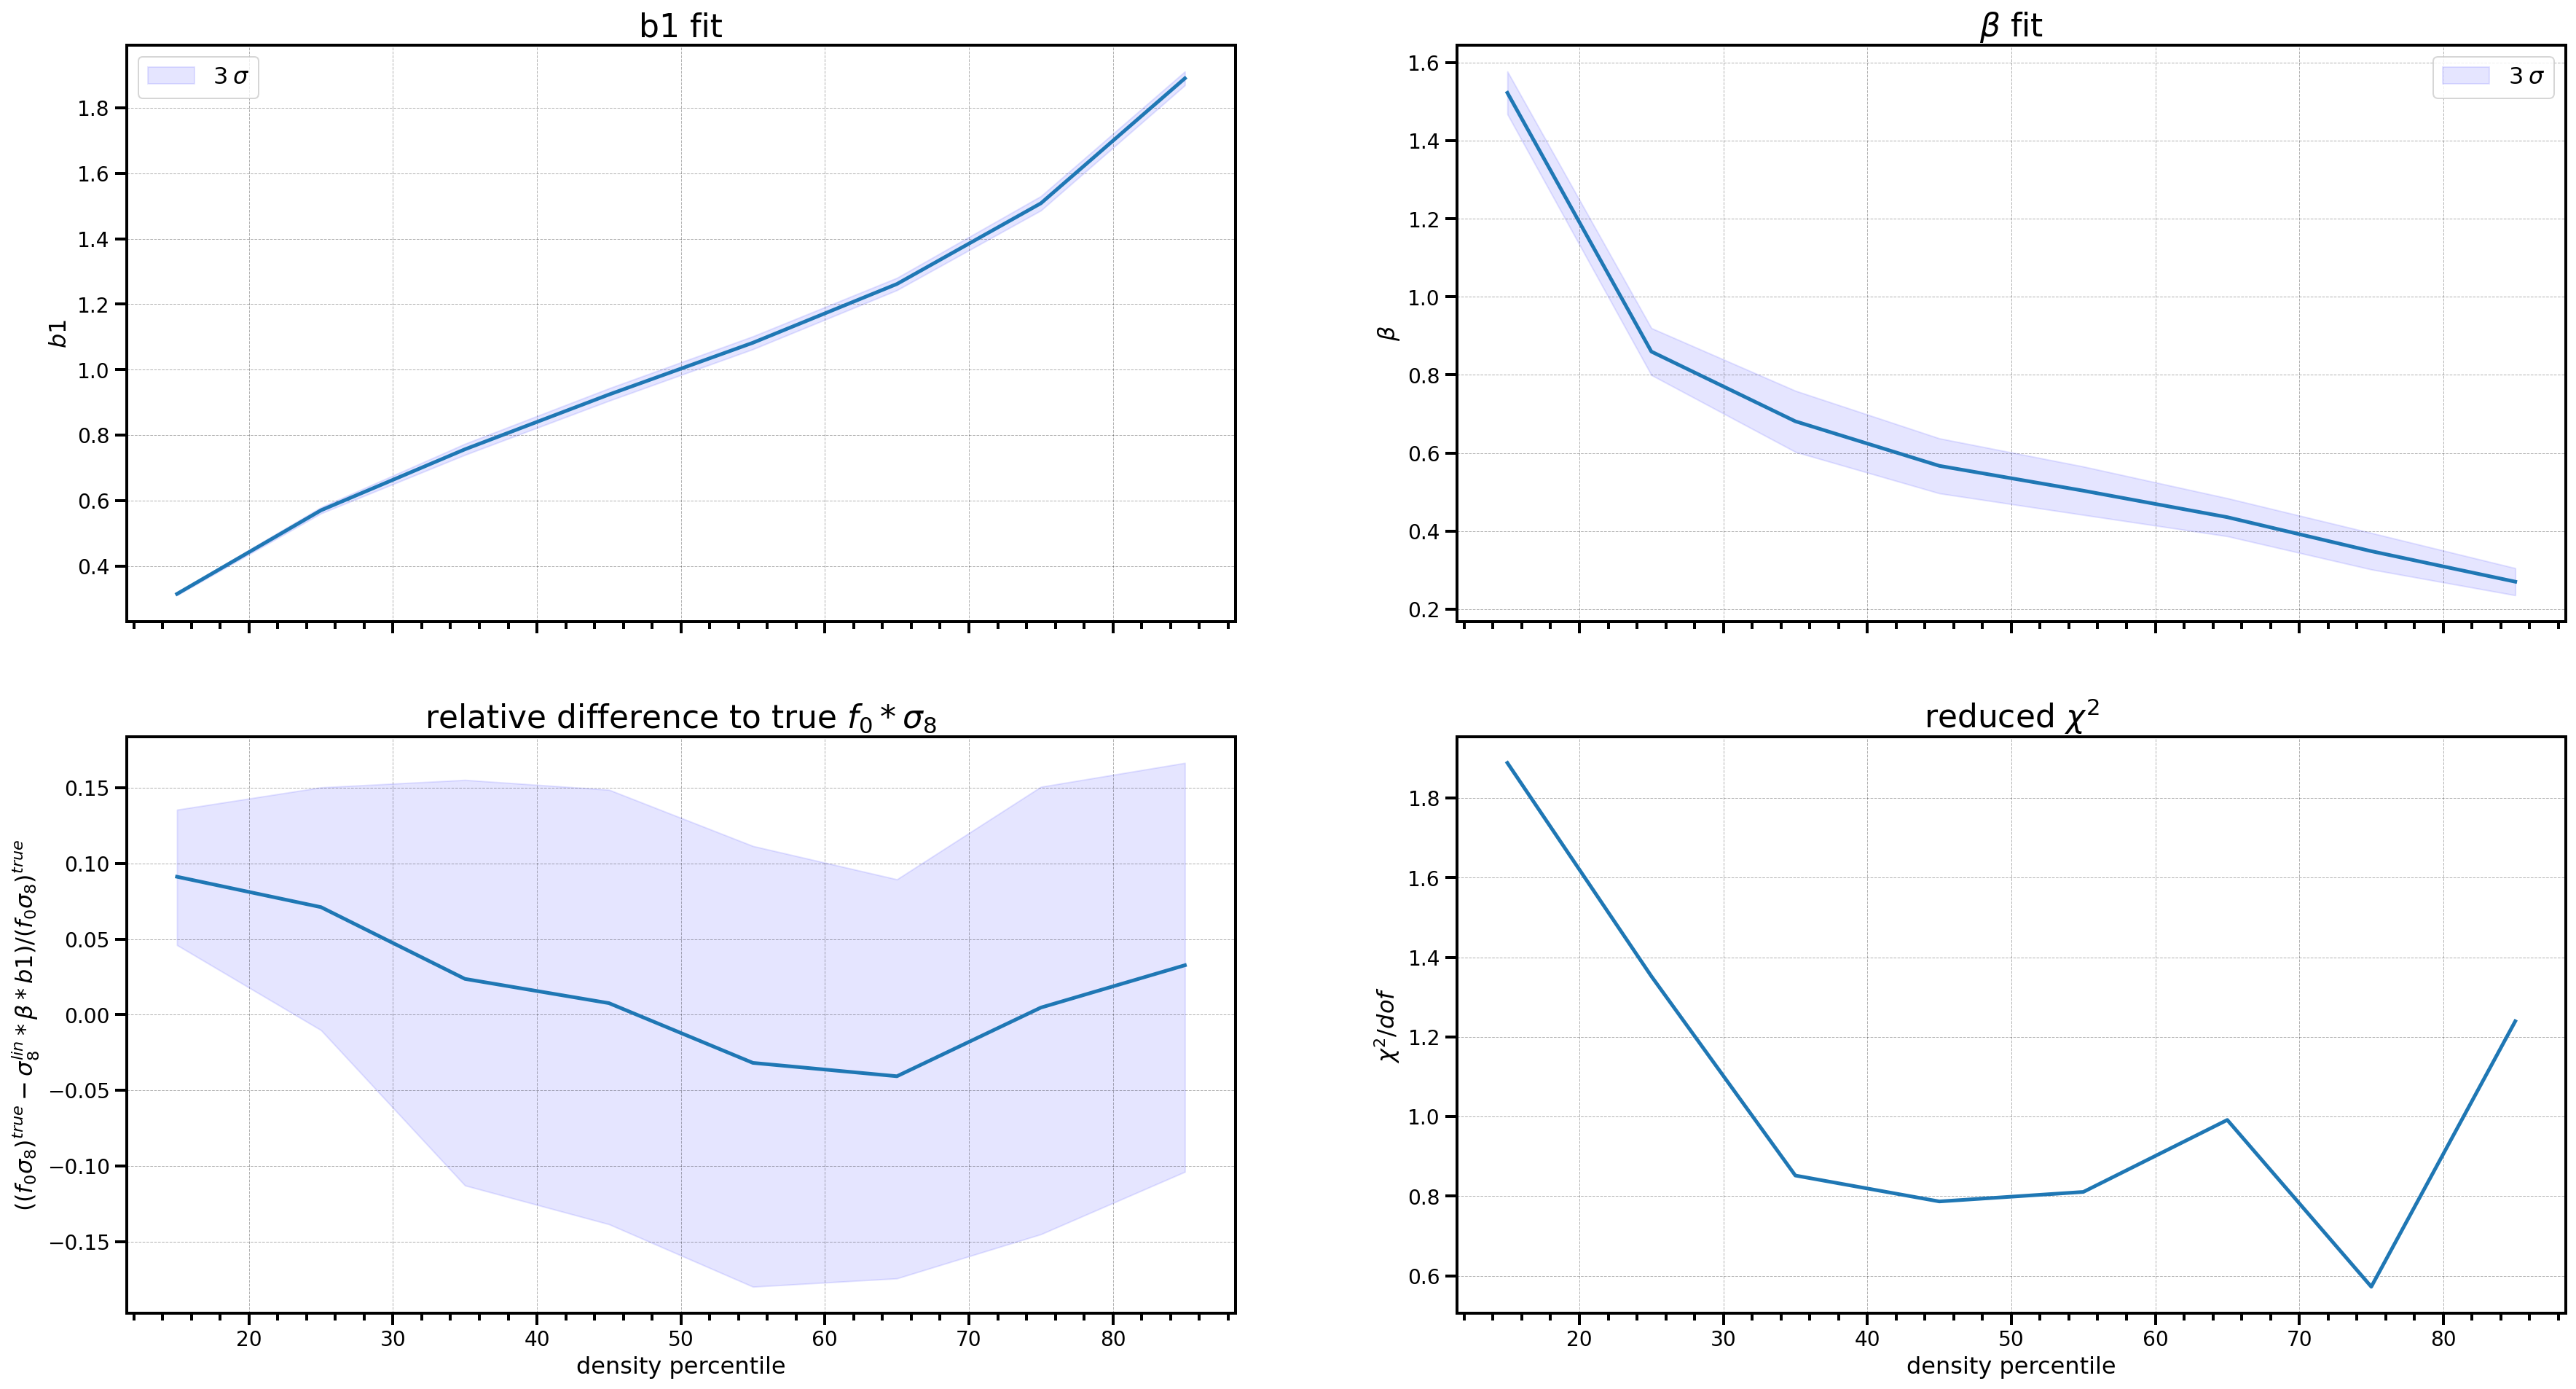

In [8]:
from matplotlib.ticker import AutoMinorLocator
fig, axs = plt.subplots(2, 2, figsize=(30,16), sharex=True)

mids = np.arange(5,105,10)[1:] # percentile mid points

axs[0][0].plot(mids, b1_fits[1:])
axs[0][0].fill_between(mids, b1_cred[:,0][1:], b1_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[0][0].set_title("b1 fit")
axs[0][0].set_ylabel(r"$b1$")
axs[0][0].legend()

axs[0][1].plot(mids, beta_fits[1:])
axs[0][1].fill_between(mids, beta_cred[:,0][1:], beta_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[0][1].set_title(r"$\beta$ fit")
axs[0][1].set_ylabel(r"$\beta$")
axs[0][1].legend()

delta_f0_sig8 = (f0_true*sigma8_true - sigma8_lin*(beta_fits*b1_fits)) / (f0_true*sigma8_true)
delta_f0_sig8_cred = (f0_true*sigma8_true - sigma8_lin*(beta_cred*b1_cred)) / (f0_true*sigma8_true)
axs[1][0].plot(mids, delta_f0_sig8[1:])
axs[1][0].fill_between(mids, delta_f0_sig8_cred[:,0][1:], delta_f0_sig8_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[1][0].set_title(r"relative difference to true $f_0*\sigma_8$")
axs[1][0].set_xlabel("density percentile")
axs[1][0].set_ylabel(r"$((f_0\sigma_8)^{true} - \sigma_8^{lin}*\beta*b1)/(f_0\sigma_8)^{true}$")
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())

axs[1][1].plot(mids, reduced_chi2[1:])
axs[1][1].set_title("reduced $\chi^2$")
axs[1][1].set_xlabel("density percentile")
axs[1][1].set_ylabel(r"$\chi^2 / dof$")
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())

plt.show()
#fig.savefig('plots/Fitting_b1_beta_densitybins_ABC.pdf')

### Interpretation
The ball park of the fitted parameter is similar to the one found in the fitting via minimizing chi2. The issue with the first percentile remains: The quadrupole moment is entirely negative such that a negative beta is fitted which gives a good chi2 but a wrong $f_0*\sigma_8$. The first and last percentile have much lower acceptance rates than the other bins. To assure that enough parameters have been accepted for statistical significance, we repeat the sampling so many times, until a desired number of accepted parameter is reached. However, for the highest bin, the condition of $\chi^2<2$ is too strict such that usually no parameters are accepted. Even a significantly larger bound of 10 doesn't resolve the issue. Hence the bin is skipped.

The estimated $f_0*\sigma_8$ is better in this fit is better compared to the one from minimizing chi2. But the credibility level is rather wide. Interestingly, the tendency to underestimate $f_0*\sigma_8$ as seen in `Fit_b1_beta_minchi2.ipynb`. 

Note on the credibility interval for reduced difference to $f_0*\sigma_8$: credibility interval is not an error. Hence no need to propagate the credibility intervals (='error') or b1 and beta.